# Classifying brain tumor as Malignant or Benign based on images from MRI scans using a convolutional Neural Network
<br>

![alt_text](./images/background.png)

## 1) First let's import all the necessary modules
<br>

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
tf.random.set_seed(1)
os.environ['PYTHONHASHSEED']=str(1)
np.random.seed(1)
random.seed(1)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 2) Data preprocessing and visualization

### 2.1 Loading the data in X and y(labels)
* X has the image arrays
* y has 0(image is benign) or 1(image is malignant)

In [4]:
def load_data():
    DATADIR = os.getcwd() + '/brain_tumor_dataset/augmented_data'
    pathstodir = [os.path.join(DATADIR, x) for x in ['yes', 'no']]
    
    label = 1
    y = []
    X = []
    for dir_path in pathstodir:
        for img in os.listdir(dir_path):
            # full path to the image
            fpath = os.path.join(dir_path, img)
            # shape(240,240)
            img = plt.imread(fpath) 
            img = img.reshape(240,240,1)
            X.append(img)
            y.append([label])
        label -= 1
    return np.array(X), np.array(y)

In [5]:
X, y = load_data()
print(r"We have {nimg} images with shape - {nshape} each.".format(nimg=X.shape[0], nshape=X.shape[1:]))
print(r"We have {nimg} images with shape - {nshape} each.".format(nimg=y.shape[0], nshape=y.shape[1:]))

We have 2738 images with shape - (240, 240, 1) each.
We have 2738 images with shape - (1,) each.


### 2.2 Let's print some random images to see 
<br>

In [6]:
import random
def print_random_images(x, y):
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        index = random.randint(0, len(x) -1)
        img = x[index]
        title = ""
        
        if y[index][0] == 0:
            title = "Benign"
        else:
            title = "Malignant"
            
        axes = fig.add_subplot(rows, columns, i, title=title)
        fig.tight_layout(pad=2.0)
        axes.axis('off')
        plt.imshow(img, cmap='gray')
        
    plt.show()

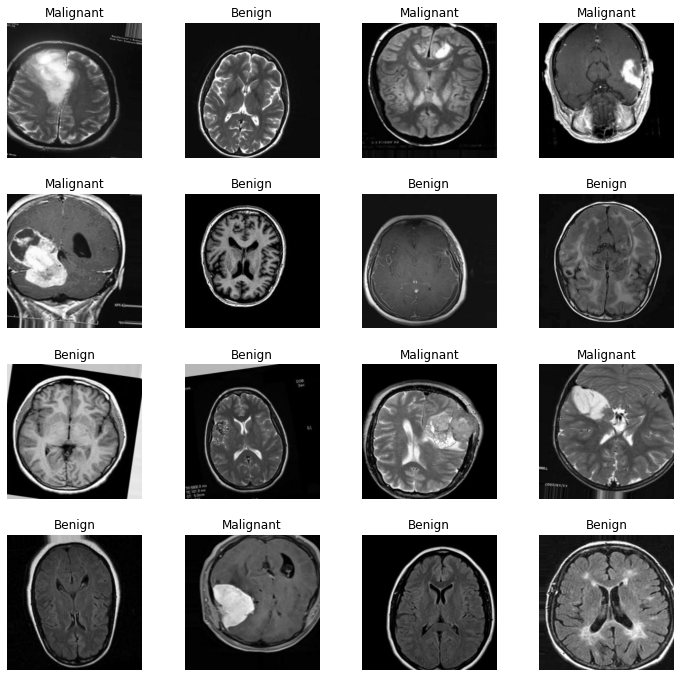

In [7]:
print_random_images(X, y) # run this code block again to see different random set

`Malignant:` The tumor contains abnormal cells that have the potential to become cancerous.
<br>
`Benign:` It refers to a condition, tumor, or growth that is not cancerous, meaning it does not spread to other parts of the body.
<br>
<br>
#### To Remember
* Just looking at the data we can see that the Malignant ones have a noticably bigger lump of tumor. 
* Whereas the  Benign case is smaller.
* Just because the tumor exists doesn't necessarily mean it's malignant case

### 2.3 Now let's randomly shuffle the data
<br>

In [8]:
def random_shuffled_copies(a, b): # randomly shuffle the dataset
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, y = random_shuffled_copies(X, y)

### 2.4 Splitting the data into train, test and validation
<br>

In [9]:
# 85% of the data used for training and 15% for validation/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Number of training examples: ", len(X_train))
print("Number of validation examples: ", len(X_val))
print("Number of testing examples: ", len(X_test))

Number of training examples:  2190
Number of validation examples:  274
Number of testing examples:  274


In [10]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

## 3) Model
<br>

### 3.1 Creating a model
<br>

![alt text](./images/cnn.png)

In [11]:
model = Sequential()

model.add(Conv2D(16, (5, 5), strides=(2,2), padding='same',input_shape=(240,240,1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((4, 4)))

model.add(Conv2D(32, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((4, 4)))

model.add(Conv2D(64, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(10, 'relu'))
model.add(Dense(1, 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0

### 3.2 Creating a callback to stop the training loop when desired accuracy is reached

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') >= 0.85):
            print('\n\nReached 85% accuracy so cancelling training!\n\n')
            self.model.stop_training = True

callB = myCallback()

### 3.2 Training the model

In [13]:
model.compile(optimizer=Adam(lr=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[callB])

Epoch 1/30
69/69 [==============================] - 9s 134ms/step - loss: 0.6704 - accuracy: 0.6087 - val_loss: 0.7168 - val_accuracy: 0.4307
Epoch 2/30
69/69 [==============================] - 3s 42ms/step - loss: 0.5584 - accuracy: 0.7187 - val_loss: 0.6987 - val_accuracy: 0.4453
Epoch 3/30
69/69 [==============================] - 3s 43ms/step - loss: 0.5080 - accuracy: 0.7511 - val_loss: 0.6642 - val_accuracy: 0.6606
Epoch 4/30
69/69 [==============================] - 3s 43ms/step - loss: 0.4823 - accuracy: 0.7689 - val_loss: 0.6468 - val_accuracy: 0.6277
Epoch 5/30
69/69 [==============================] - 3s 43ms/step - loss: 0.4565 - accuracy: 0.7831 - val_loss: 0.6464 - val_accuracy: 0.5876
Epoch 6/30
69/69 [==============================] - 3s 43ms/step - loss: 0.4392 - accuracy: 0.7995 - val_loss: 0.6638 - val_accuracy: 0.5912
Epoch 7/30
69/69 [==============================] - 3s 43ms/step - loss: 0.4198 - accuracy: 0.8114 - val_loss: 0.6424 - val_accuracy: 0.6314
Epoch 8/30
6

In [14]:
model.save('85best_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 85best_model/assets


### The model is trained now let's see the loss and accuracy
<br>

Text(0, 0.5, 'loss')

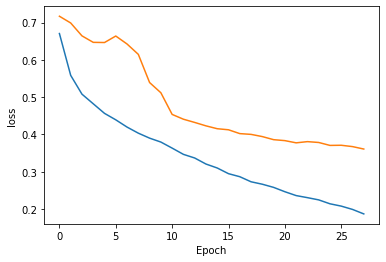

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

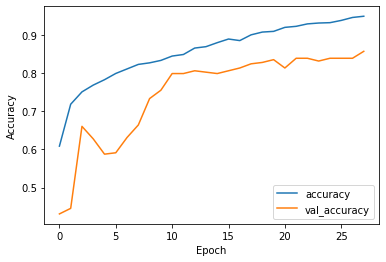

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 3.3 Making predictions with test set

In [17]:
preds = model.predict(X_test) # first two, predictions with highest probability are right

In [18]:
correct_preds = 0
incorrect_preds = 0
for i in range(len(preds)):
    temp_preds = 0
    
    if preds[i][0] > 0.5:
        temp_preds = 1
    if temp_preds == y_test[i][0]:
        correct_preds += 1
    else:
        incorrect_preds +=1
        
print(f"Correct predictions: {100 * correct_preds / len(preds):.2f}")
print(f"Incorrect predictions: {100 * incorrect_preds / len(preds):.2f}")

Correct predictions: 86.50
Incorrect predictions: 13.50


### Below are the images the model has classified
* Note that these images are from test set which is never seen by model

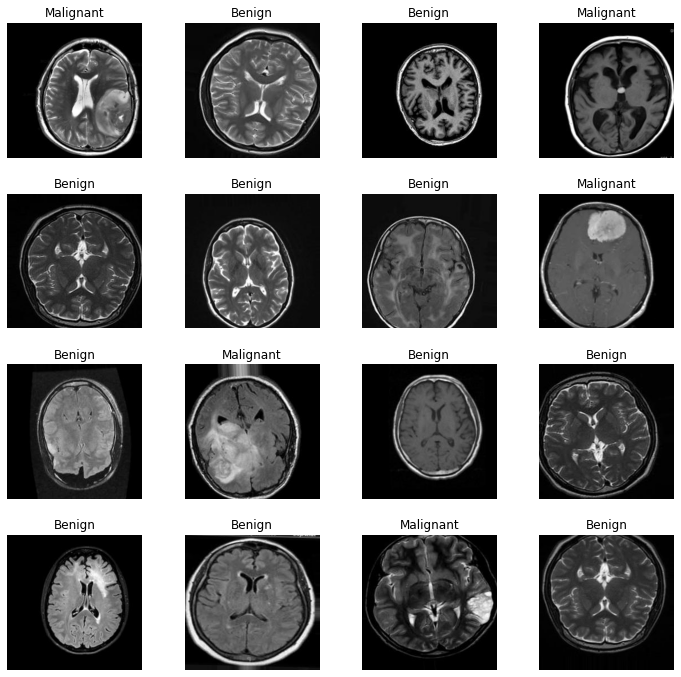

In [19]:
print_random_images(X_test, y_test)

## 4) Conclusion
<br>

In [20]:
def conclusion_summary():
    result_train = model.evaluate(X_train, y_train, verbose=0)
    result_test = model.evaluate(X_test, y_test, verbose=0)
    print(f"Training accuracy of {result_train[1] * 100:.2f}")
    print(f"Test accuracy of {result_test[1] * 100:.2f}")   

### With just 23 epochs we are able to get,

In [21]:
conclusion_summary() 

Training accuracy of 95.34
Test accuracy of 86.50


### Not too bad for a dataset with just 2738 augmented images.

### Testing your own image
* You can download an image from google and test it using the function below
* Place the image in the root directory itself `/BrainNet`
* And change the modify the variable `your_img` with name of your image with extension.
* Don't need to retrain the model as I've already trained and saved the best accuracy model.

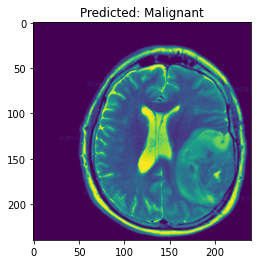

In [46]:
from PIL import Image
from tensorflow.keras.models import load_model

index = 1
model = load_model('85best_model')
pred = model.predict(np.expand_dims(X_test[index], axis=0))
plt.imshow(X_test[index])

if y_test[index][0] == 0:
    plt.title('Predicted: Benign')
else:
    plt.title('Predicted: Malignant')
